# Import

In [1]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from causalml.inference.meta import (
    BaseDRLearner,
    BaseRLearner,
    BaseXLearner,
    BaseSLearner,
    BaseTLearner,
    BaseRClassifier,
    BaseXClassifier,
    BaseTClassifier,
    BaseSClassifier,
    BaseDRRegressor
)
from causalml.inference.torch import CEVAE

from cate.dataset import Dataset
from cate.utils import PathLinker, Timer

/workspace/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pathlinker = PathLinker().data.criteo
timer = Timer()

# Functions

In [3]:
def to_rank(
    primary_key: pd.Series, score: pd.Series, ascending: bool = True
) -> pd.Series:
    df = pd.DataFrame({primary_key.name: primary_key, score.name: score}).set_index(
        primary_key.name, drop=True
    )
    df = df.sort_values(by=score.name, ascending=ascending)  # type: ignore
    df["rank"] = np.ceil(np.arange(len(df)) / len(df) * 100).astype(int)
    return df["rank"]

# Read Data

In [4]:
ds = Dataset.load(pathlinker.base)

# Model

In [5]:
# base_model = lgb.LGBMClassifier(importance_type="gain")
# names = [
#     "slearner",
#     "tlearner",
#     "xlearner",
#     "drlearner",
#     "rlearner",
#     "cevae",
# ]
# models = [
#     BaseSLearner(base_model),
#     BaseTLearner(base_model, base_model, base_model),
#     BaseXLearner(base_model, base_model, base_model),
#     BaseDRLearner(base_model, base_model, base_model, base_model),
#     BaseRLearner(base_model, base_model, base_model),
#     CEVAE(),
# ]

In [9]:
base_classifier = lgb.LGBMClassifier(importance_type="gain")
base_regressor = lgb.LGBMRegressor(importance_type="gain")
names = [
    "drlearner",
    "xlearner",
    "rlearner",
    "slearner",
    "tlearner",
    # "cevae",
]

models = [
    BaseDRLearner(base_regressor),
    BaseXClassifier(base_classifier, base_regressor),
    BaseRClassifier(base_classifier, base_regressor),
    BaseSClassifier(base_classifier),
    BaseTClassifier(base_classifier),
    # CEVAE(),
]

In [10]:
np.int = int

In [11]:
pred_dfs = {}
skf = StratifiedKFold(5, shuffle=True, random_state=42)
for name, model in zip(names, models):
    _pred_dfs = []
    for i, (train_idx, valid_idx) in tqdm(
        enumerate(skf.split(np.zeros(len(ds)), ds.y))
    ):
        train_X = ds.X.iloc[train_idx]
        train_y = ds.y.iloc[train_idx].to_numpy().reshape(-1)
        train_w = ds.w.iloc[train_idx].to_numpy().reshape(-1)
        valid_X = ds.X.iloc[valid_idx]
        valid_y = ds.y.iloc[valid_idx].to_numpy().reshape(-1)
        valid_w = ds.w.iloc[valid_idx].to_numpy().reshape(-1)

        timer.start(f"fit_{name}_{i}")
        model.fit(train_X, train_w, train_y)
        timer.stop(f"fit_{name}_{i}")

        timer.start(f"predict_{name}_{i}")
        pred = model.predict(valid_X)
        timer.stop(f"predict_{name}_{i}")

        _pred_dfs.append(
            pd.DataFrame({"index": ds.y.index[valid_idx], "pred": pred.reshape(-1)})
        )  # type: ignore
    pred_dfs[name] = _pred_dfs

0it [00:00, ?it/s]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:34

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1256
[LightGBM] [Info] Number of data points in the train set: 5497, number of used features: 12
[LightGBM] [Info] Start training from score 0.001455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 31782, number of used features: 12
[LightGBM] [Info]

/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarn

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1102
[LightGBM] [Info] Number of data points in the train set: 5614, number of used features: 12
[LightGBM] [Info] Start training from score 0.002138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_row_wise=true` to remo

/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarn

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 5709, number of used features: 12
[LightGBM] [Info] Start training from score 0.000350
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

1it [02:33, 153.34s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1256
[LightGBM] [Info] Number of data points in the train set: 5617, number of used features: 12
[LightGBM] [Info] Start training from score 0.001246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001976 seconds.
You can set `force_row_wise=true` to remo

/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarn

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 5622, number of used features: 12
[LightGBM] [Info] Start training from score 0.001957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1655
[LightGBM] [Info] Number of data points in the train set: 31657, number of used features: 12
[LightGBM] [Info]

/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarn

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 5581, number of used features: 12
[LightGBM] [Info] Start training from score 0.001971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number

2it [05:09, 154.79s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1258
[LightGBM] [Info] Number of data points in the train set: 5534, number of used features: 12
[LightGBM] [Info] Start training from score 0.001626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarn

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1285
[LightGBM] [Info] Number of data points in the train set: 5664, number of used features: 12
[LightGBM] [Info] Start training from score 0.002119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 31615, number of used features: 12
[LightGBM] [Info]

/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarn

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1250
[LightGBM] [Info] Number of data points in the train set: 5637, number of used features: 12
[LightGBM] [Info] Start training from score 0.001597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1653
[LightGBM] [Info] Number of data points in the train set: 31642, number of used features: 12
[Light

3it [07:38, 152.43s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1264
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 12
[LightGBM] [Info] Start training from score 0.001758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1655
[LightGBM] [Info] Number of data points in the train set: 31591, number of used features: 12
[Light

/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarn

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1251
[LightGBM] [Info] Number of data points in the train set: 5543, number of used features: 12
[LightGBM] [Info] Start training from score 0.001624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_row_wise=true` to remo

/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarn

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 5618, number of used features: 12
[LightGBM] [Info] Start training from score 0.001602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data po

4it [10:06, 150.61s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1263
[LightGBM] [Info] Number of data points in the train set: 5608, number of used features: 12
[LightGBM] [Info] Start training from score 0.001783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_row_wise=true` to remo

/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarn

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1267
[LightGBM] [Info] Number of data points in the train set: 5669, number of used features: 12
[LightGBM] [Info] Start training from score 0.001764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarn

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 5591, number of used features: 12
[LightGBM] [Info] Start training from score 0.001252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1654
[LightGBM] [Info] Number of data points in the train set: 31688, number of used features: 12
[LightGBM] [Info] Start training from score 0.003408
[LightGBM] [Info] Auto-choosing row-wis

5it [12:34, 150.80s/it]
0it [00:00, ?it/s]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn

[LightGBM] [Info] Number of positive: 22, number of negative: 16798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1612
[LightGBM] [Info] Number of data points in the train set: 16820, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001308 -> initscore=-6.637973
[LightGBM] [Info] Start training from score -6.637973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 327, number of negative: 94689
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points i

1it [02:29, 149.75s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 29, number of negative: 16791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 16820, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001724 -> initscore=-6.361302
[LightGBM] [Info] Start training from score -6.361302
[LightGBM] [Info] Number of positive: 321, number of negative: 94696
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 95017, number of used features: 12
[LightGBM] [Info] [bina

2it [05:00, 150.19s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 30, number of negative: 16805
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 16835, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001782 -> initscore=-6.328234
[LightGBM] [Info] Start training from score -6.328234
[LightGBM] [Info] Number of positive: 320, number of negative: 94682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 95002, number of used features: 12
[LightGBM] [Info] [bina

3it [07:28, 149.51s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 28, number of negative: 16821
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1524
[LightGBM] [Info] Number of data points in the train set: 16849, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001662 -> initscore=-6.398179
[LightGBM] [Info] Start training from score -6.398179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 322, number of negative: 94666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1680
[LightGBM] [Info] Number of data points i

4it [10:00, 150.45s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 27, number of negative: 16841
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 16868, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001601 -> initscore=-6.435735
[LightGBM] [Info] Start training from score -6.435735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

5it [12:31, 150.37s/it]
0it [00:00, ?it/s]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn

[LightGBM] [Info] Number of positive: 261, number of negative: 89208
[LightGBM] [Info] Number of positive: 294, number of negative: 89174
[LightGBM] [Info] Number of positive: 272, number of negative: 89197
[LightGBM] [Info] Number of positive: 287, number of negative: 89182
[LightGBM] [Info] Number of positive: 282, number of negative: 89187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set 

1it [02:50, 170.64s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 284, number of negative: 89186
[LightGBM] [Info] Number of positive: 273, number of negative: 89197
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1682
[LightGBM] [Info] Number of data points in the train set: 89470, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003174 -> initscore=-5.749505
[LightGBM] [Info] Start training from score -5.749505
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1674
[LightGBM] [Info] Number of data points in the train set: 89470, number of used features: 12
[LightGBM] [Info] [bin

2it [05:35, 167.39s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 281, number of negative: 89188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1674
[LightGBM] [Info] Number of data points in the train set: 89469, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003141 -> initscore=-5.760147
[LightGBM] [Info] Start training from score -5.760147
[LightGBM] [Info] Number of positive: 271, number of negative: 89198
[LightGBM] [Info] Number of positive: 271, number of negative: 89199
[LightGBM] [Info] Number of positive: 287, number of negative: 89183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

3it [08:09, 161.25s/it]/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

[LightGBM] [Info] Number of positive: 277, number of negative: 89192
[LightGBM] [Info] Number of positive: 272, number of negative: 89197
[LightGBM] [Info] Number of positive: 277, number of negative: 89193
[LightGBM] [Info] Number of positive: 282, number of negative: 89188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 89469, number of used features: 12
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1677
[LightGBM] [Info] Number of data points in the train set: 89469, number of used features: 12
[LightGBM] [Info] 

4it [10:40, 157.19s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 111837, number of used features: 12
[LightGBM] [Info] Start training from score 0.001582


/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/workspace/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarn

[LightGBM] [Info] Number of positive: 281, number of negative: 89188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1669
[LightGBM] [Info] Number of data points in the train set: 89469, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003141 -> initscore=-5.760147
[LightGBM] [Info] Start training from score -5.760147
[LightGBM] [Info] Number of positive: 273, number of negative: 89196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 89469, number of used features: 12
[LightGBM] [Info] [bin

5it [13:14, 158.98s/it]
0it [00:00, ?it/s]

[LightGBM] [Info] Number of positive: 349, number of negative: 111487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1682
[LightGBM] [Info] Number of data points in the train set: 111836, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003121 -> initscore=-5.766591
[LightGBM] [Info] Start training from score -5.766591


1it [00:00,  1.49it/s]

[LightGBM] [Info] Number of positive: 350, number of negative: 111487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 111837, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003130 -> initscore=-5.763730
[LightGBM] [Info] Start training from score -5.763730


2it [00:01,  1.56it/s]

[LightGBM] [Info] Number of positive: 350, number of negative: 111487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1684
[LightGBM] [Info] Number of data points in the train set: 111837, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003130 -> initscore=-5.763730
[LightGBM] [Info] Start training from score -5.763730


3it [00:01,  1.77it/s]

[LightGBM] [Info] Number of positive: 350, number of negative: 111487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1685
[LightGBM] [Info] Number of data points in the train set: 111837, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003130 -> initscore=-5.763730
[LightGBM] [Info] Start training from score -5.763730


4it [00:02,  1.90it/s]

[LightGBM] [Info] Number of positive: 349, number of negative: 111488
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1687
[LightGBM] [Info] Number of data points in the train set: 111837, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003121 -> initscore=-5.766600
[LightGBM] [Info] Start training from score -5.766600


5it [00:02,  1.84it/s]
0it [00:00, ?it/s]

[LightGBM] [Info] Number of positive: 22, number of negative: 16798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1612
[LightGBM] [Info] Number of data points in the train set: 16820, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001308 -> initscore=-6.637973
[LightGBM] [Info] Start training from score -6.637973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 327, number of negative: 94689
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points i

1it [00:00,  1.66it/s]

[LightGBM] [Info] Number of positive: 29, number of negative: 16791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 16820, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001724 -> initscore=-6.361302
[LightGBM] [Info] Start training from score -6.361302
[LightGBM] [Info] Number of positive: 321, number of negative: 94696
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 95017, number of used features: 12
[LightGBM] [Info] [bina

2it [00:01,  1.70it/s]

[LightGBM] [Info] Number of positive: 30, number of negative: 16805
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 16835, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001782 -> initscore=-6.328234
[LightGBM] [Info] Start training from score -6.328234
[LightGBM] [Info] Number of positive: 320, number of negative: 94682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 95002, number of used features: 12
[LightGBM] [Info] [bina

3it [00:01,  1.83it/s]

[LightGBM] [Info] Number of positive: 28, number of negative: 16821
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1524
[LightGBM] [Info] Number of data points in the train set: 16849, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001662 -> initscore=-6.398179
[LightGBM] [Info] Start training from score -6.398179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 322, number of negative: 94666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1680
[LightGBM] [Info] Number of data points i

4it [00:02,  1.96it/s]

[LightGBM] [Info] Number of positive: 27, number of negative: 16841
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 16868, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001601 -> initscore=-6.435735
[LightGBM] [Info] Start training from score -6.435735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

5it [00:02,  1.90it/s]


In [12]:
output_df = pd.merge(ds.y.copy(), ds.w.copy(), left_index=True, right_index=True)
for name, pred_df_list in pred_dfs.items():
    pred_df = pd.concat(pred_df_list, axis=0)
    rank = to_rank(pred_df["index"], pred_df["pred"], ascending=False)
    pred_df = pd.merge(pred_df, rank, left_on="index", right_index=True).set_index(
        "index", drop=True
    )
    pred_df = pred_df.rename(columns={"pred": f"{name}_pred", "rank": f"{name}_rank"})
    output_df = pd.merge(output_df, pred_df, left_index=True, right_index=True)
output_df.to_csv(pathlinker.prediction / "metaleaner.csv")

In [13]:
cvs = {}
for name in names:
    cv_list = []
    for rank in range(100):
        rank_flg = output_df[f"{name}_rank"] <= rank
        tg_flg = output_df["treatment"] == 1
        cv = (
            output_df.loc[rank_flg & tg_flg, "conversion"].mean()
            - output_df.loc[rank_flg & ~tg_flg, "conversion"].mean()
        )
        cv_list.append(cv)
    cvs[name] = cv_list

In [14]:
cv_df = pd.DataFrame(cvs)
cv_df.to_csv("/workspace/outputs/meta_learner.csv", index=False)

<Axes: >

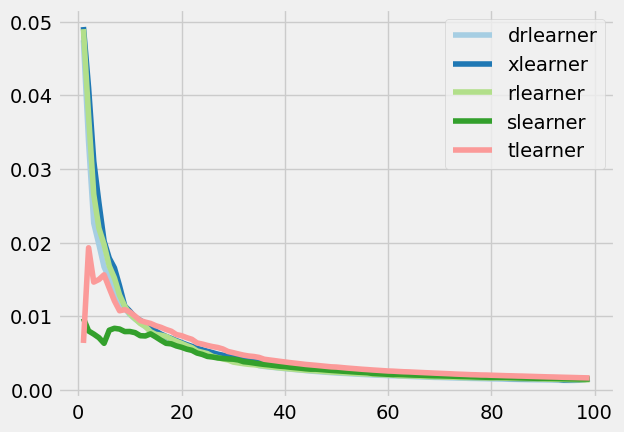

In [15]:
cv_df.plot()

In [16]:
timer.to_csv(pathlinker.prediction / "metalearner_duration.csv")